故障情况：

1. * 故障发生时间：2018-06-27 09:06:00
  * 描述： 重齿厂家巡检时发现主齿轮箱前轴承内圈脱落，存在安全隐患，现场无备件，现故障运行，待备件到货后更换。
  * 故障更换完成时间：未处理
2. * 故障发生时间：2018-07-08 08:07:00
  * 描述：   厂家巡检时发现3#机组齿轮箱高速轴轴承内圈脱落，齿面有异常磨损，已发备件到现场完成更换。
  * 故障更换完成时间：2018-07-09 20:10:00

In [1]:
import os
import sys
sys.path.append("../../")
from imp import reload

import Reader
import toolkit
import visualization
# import GearboxFaultDetector
import model_entry

Using TensorFlow backend.
D:\Software\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# reload(Reader)

In [3]:
feature_path = r"D:/Workspace/python_workspace/gearbox-fault-detection/local/feature/li_niu_ping/"
speed_path = r"D:\Workspace\python_workspace\gearbox-fault-detection\local\rotating_speed\li_niu_ping"
wind_farm = "li niu ping"
wind_turbine = "3"
sensors = (
    "gearbox",
    "low_speed_shaft",
    "high_speed_shaft",
)

In [4]:
reader = Reader.Reader()
feature = reader.read_feature(os.path.join(feature_path, wind_turbine), sensors)
speed = reader.read_speed(os.path.join(speed_path, wind_turbine), sensors)
feature = feature.loc[speed.index]
toolkit.print_shape(feature=feature)

feature.shape: (1243, 75)


array([[<AxesSubplot:title={'center':'speed'}>]], dtype=object)

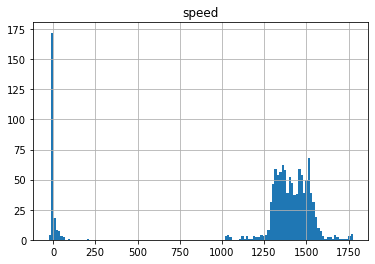

In [5]:
speed.hist(bins=128)

feature.shape: (1027, 75)
speed.shape: (1027, 1)


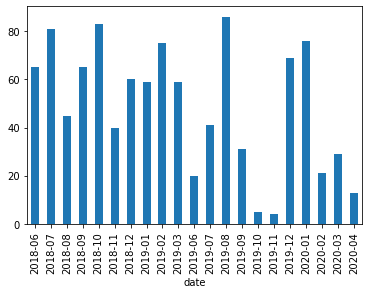

In [6]:
feature = feature[speed.speed >= 250]
speed = speed[speed.speed >= 250]

toolkit.print_shape(feature=feature, speed=speed)

visualization.data_distribution(feature)

In [7]:
# 划分train set, test set
train_start = "2018-09"
train_end = "2020"

test_start = "2018-06"
test_end = "2018-10"

feature_train = feature[train_start: train_end]
# speed_train = speed[train_start: train_end]

feature_test = feature[test_start: test_end]
# speed_test = speed[test_start: test_end]

toolkit.print_shape(feature_train=feature_train, feature_test=feature_test)

feature_train.shape: (836, 75)
feature_test.shape: (339, 75)


In [8]:
# feature_test = feature
# speed_test = speed

In [9]:
detector = model_entry.OutlierDetector()

In [10]:
detector.fit(feature_train)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.











<AxesSubplot:xlabel='date'>

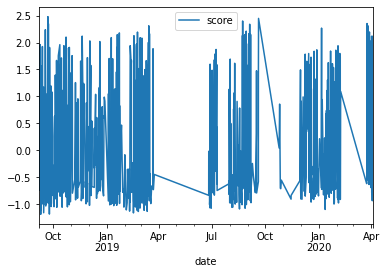

In [11]:
detector.decision_scores.plot()

In [12]:
anomaly_scores = detector.decision_function(feature_test)

<AxesSubplot:xlabel='date'>

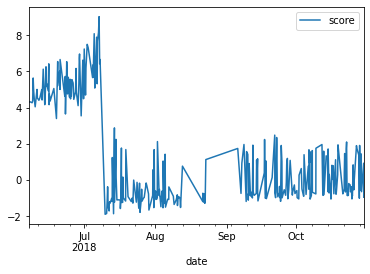

In [13]:
anomaly_scores.plot()

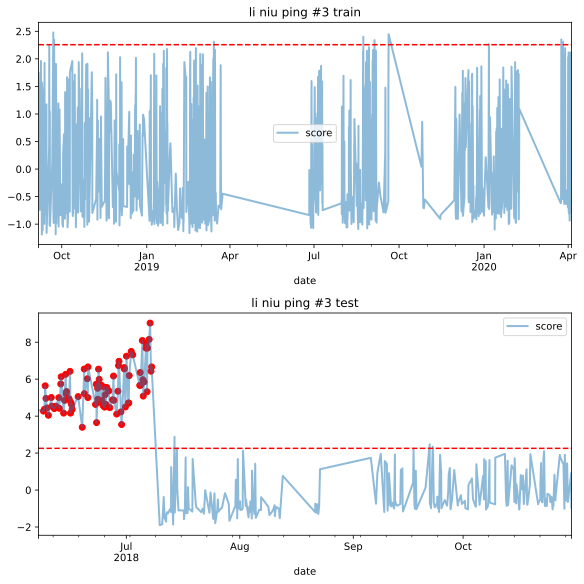

In [14]:
anomaly_scores_train = detector.decision_scores
label_train = detector.label
# 测试
anomaly_scores_test = detector.decision_function(feature_test)
label_test = detector.predict(feature_test)
fig, ax = visualization.plot_line(anomaly_scores_train, label_train,
    anomaly_scores_test, label_test, detector.threshold, wind_farm, 
    wind_turbine)

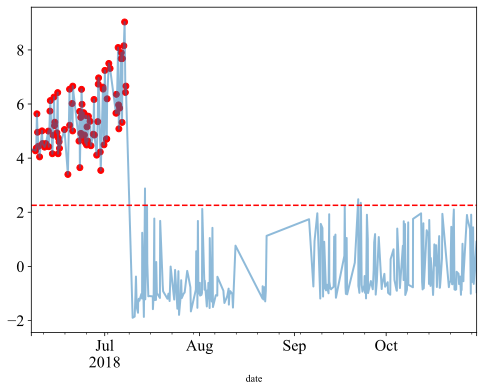

In [15]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
config = {
    "font.family":'Times New Roman',  # 设置字体类型
}
rcParams.update(config)

visualization.set_figsize(figsize=(8, 6))
fig, ax = plt.subplots()
anomaly_scores_test.plot(ax=ax, linewidth=2, alpha=0.5, legend=False, fontsize=16)
ax.plot(anomaly_scores_test.index, [detector.threshold] * len(anomaly_scores_test), "r--", label="threshold")
ax.scatter(x=anomaly_scores_test[label_test.label].index, y=anomaly_scores_test[label_test.label], c="r")


In [16]:
import pandas as pd
history = detector.detectors["auto encoder"].history_
history_df = pd.DataFrame(history)

In [17]:
history_df

,loss
0,75.204183
1,52.080182
2,32.690059
3,21.294671
4,16.535040
...,...
507,0.228930
508,0.228713
509,0.228568
510,0.228383


<AxesSubplot:>

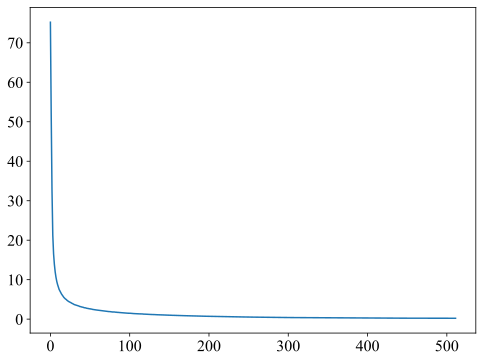

In [18]:
fig, ax = plt.subplots()
history_df.plot(ax=ax, fontsize=16, legend=False)
# ax.set_title('Model loss')
# ax.set_ylabel('Loss')
# ax.set_xlabel('Epoch')
# ax.legend(['Train'], loc='upper right')

In [19]:
label_test

,label
date,
2018-06-07 00:00,False
2018-06-07 15:00,False
2018-06-08 09:00,True
2018-06-08 15:00,True
2018-06-08 20:00,True
...,...
2018-10-29 06:00,False
2018-10-29 10:00,False
2018-10-29 15:00,False


D:\Software\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

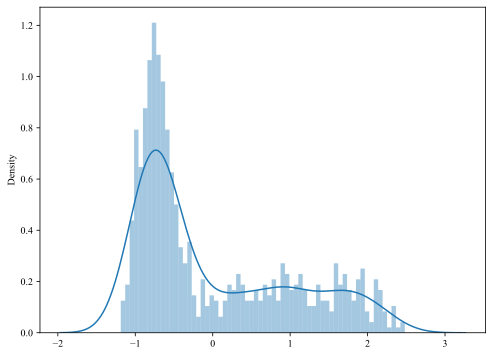

In [20]:
import seaborn as sns
sns.distplot(anomaly_scores_train, bins=64)

D:\Software\Anaconda\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

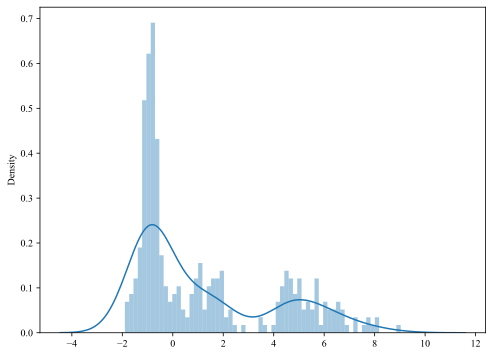

In [21]:
sns.distplot(anomaly_scores_test, bins=64)